In [2]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [4]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [5]:
dirpath = './bin/q1/SMAI-PCAdataset/IIIT-CFW/'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


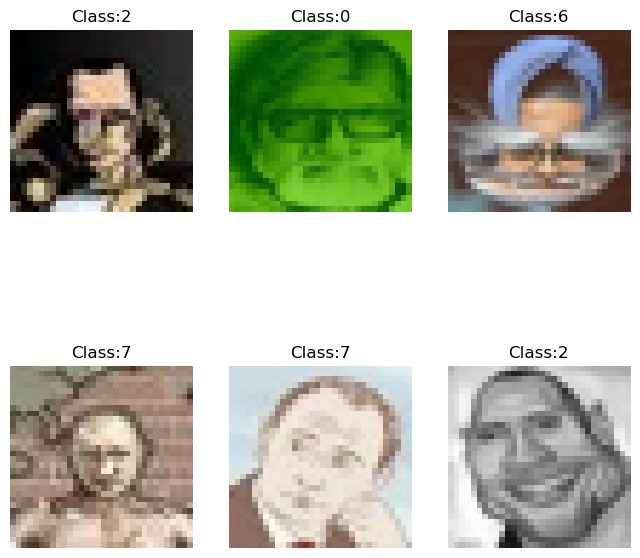

In [6]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

### 1.1 : PCA - Cumulative Explained Variance

In [7]:
reshapedX = X.reshape(X.shape[0],int(X.size/X.shape[0]))

In [8]:
# PCA
def PCAfunc(reshapedX):
    # subtracting mean from data:
    for i in range(0,len(reshapedX.T)):
        reshapedX[:,i] -= np.mean(reshapedX[:,i])
    cov_matrix = np.cov(reshapedX, rowvar=False)  # Set rowvar to False if variables are in columns

    # Perform SVD
    U, S, VT = np.linalg.svd(cov_matrix)
    U = np.copy(U.T)[np.argsort(S)][::-1]
    np.sort(S)[::-1]
    # cumExVariance
    percentVariance = np.copy(S/np.sum(S))
    cumExVariance = np.cumsum(percentVariance)
    return cumExVariance, U

In [9]:
cumExVariance = PCAfunc(reshapedX)[0]

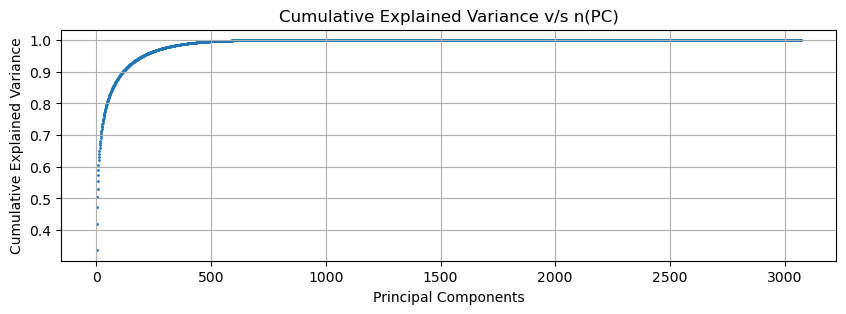

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.scatter(np.arange(1,len(cumExVariance)+1,1),cumExVariance, s=1)
plt.xlabel("Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance v/s n(PC)")
plt.grid()

### 1.1: Dimensionality reduction on Pictionary Dataset

In [11]:
# Getting data from pictionary dataset
pictionaryData = np.load("./bin/q1/data.npy",allow_pickle=True)

Xtemp = pictionaryData[:,1]
myList1 = [i.flatten() for i in Xtemp]

Xtemp = pictionaryData[:,2]
myList2 = [i.flatten() for i in Xtemp]

resnetEmbeddings = np.array(myList1)
vitEmbeddings = np.array(myList2)
yPictionary = pictionaryData[:,3]
print(resnetEmbeddings.shape, vitEmbeddings.shape)

(1500, 1024) (1500, 512)


In [12]:
PCAresnet, eVectorsResnet = PCAfunc(resnetEmbeddings)
PCAvit, eVectorsVit = PCAfunc(vitEmbeddings)

In [13]:
# Evalutating the model with PCA's
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def evaluationPlotter(X,eigenVectors,y,embeddingType):
    k = 5
    accList = []
    precisionListMicro = []
    precisionListMacro = []
    recallListMicro = []
    recallListMacro = []
    f1scoreListMicro = []
    f1scoreListMacro = []
    nPCAcomponents = [1,2,3,4,5,6,7,8,9,10,25,50,100,200,400,len(eigenVectors)]

    for PC in nPCAcomponents:
        xResnet = np.matmul(X,eigenVectors[0:PC].T)
        X_train, X_test, y_train, y_test = train_test_split(xResnet, y, test_size=0.2, random_state=42)

        model0 = KNeighborsClassifier(k)
        model0.fit(X_train,y_train)
        y_preds = model0.predict(X_test)
        
        accList.append(accuracy_score(y_test,y_preds))
        precisionListMicro.append(precision_score(y_test,y_preds,average="micro"))
        precisionListMacro.append(precision_score(y_test,y_preds,average="macro"))
        recallListMicro.append(recall_score(y_test,y_preds,average="micro"))
        recallListMacro.append(recall_score(y_test,y_preds,average="macro"))
        f1scoreListMicro.append(f1_score(y_test,y_preds,average="micro"))
        f1scoreListMacro.append(f1_score(y_test,y_preds,average="macro"))

    plt.figure(figsize=(10,14))
    plt.subplot(7,1,1)
    plt.scatter(nPCAcomponents,accList,s=10)
    plt.plot(nPCAcomponents,accList)
    plt.xlabel("No. of Principal Components")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy v/s No. of Principal components for {embeddingType} embeddings")
    plt.grid()

    plt.subplot(7,1,2)
    plt.scatter(nPCAcomponents,precisionListMicro,s=10)
    plt.plot(nPCAcomponents,precisionListMicro)
    plt.xlabel("No. of Principal Components")
    plt.ylabel("Precision (micro) ")
    plt.title(f"Precision (micro) v/s No. of Principal components for {embeddingType} embeddings")
    plt.grid()

    plt.subplot(7,1,3)
    plt.scatter(nPCAcomponents,precisionListMacro,s=10)
    plt.plot(nPCAcomponents,precisionListMacro)
    plt.xlabel("No. of Principal Components")
    plt.ylabel("Precision (macro)")
    plt.title(f"Precision (macro) v/s No. of Principal components for {embeddingType} embeddings")
    plt.grid()
    
    plt.subplot(7,1,4)
    plt.scatter(nPCAcomponents,recallListMicro,s=10)
    plt.plot(nPCAcomponents,recallListMicro)
    plt.xlabel("No. of Principal Components")
    plt.ylabel("recall (micro) ")
    plt.title(f"recall (micro) v/s No. of Principal components for {embeddingType} embeddings")
    plt.grid()

    plt.subplot(7,1,5)
    plt.scatter(nPCAcomponents,recallListMacro,s=10)
    plt.plot(nPCAcomponents,recallListMacro)
    plt.xlabel("No. of Principal Components")
    plt.ylabel("recall (macro)")
    plt.title(f"recall (macro) v/s No. of Principal components for {embeddingType} embeddings")
    plt.grid()

    plt.subplot(7,1,6)
    plt.scatter(nPCAcomponents,f1scoreListMicro,s=10)
    plt.plot(nPCAcomponents,f1scoreListMicro)
    plt.xlabel("No. of Principal Components")
    plt.ylabel("f1score (micro) ")
    plt.title(f"f1score (micro) v/s No. of Principal components for {embeddingType} embeddings")
    plt.grid()

    plt.subplot(7,1,7)
    plt.scatter(nPCAcomponents,f1scoreListMacro,s=10)
    plt.plot(nPCAcomponents,f1scoreListMacro)
    plt.xlabel("No. of Principal Components")
    plt.ylabel("f1score (macro)")
    plt.title(f"f1score (macro) v/s No. of Principal components for {embeddingType} embeddings")
    plt.grid()

    plt.tight_layout()
    plt.show()

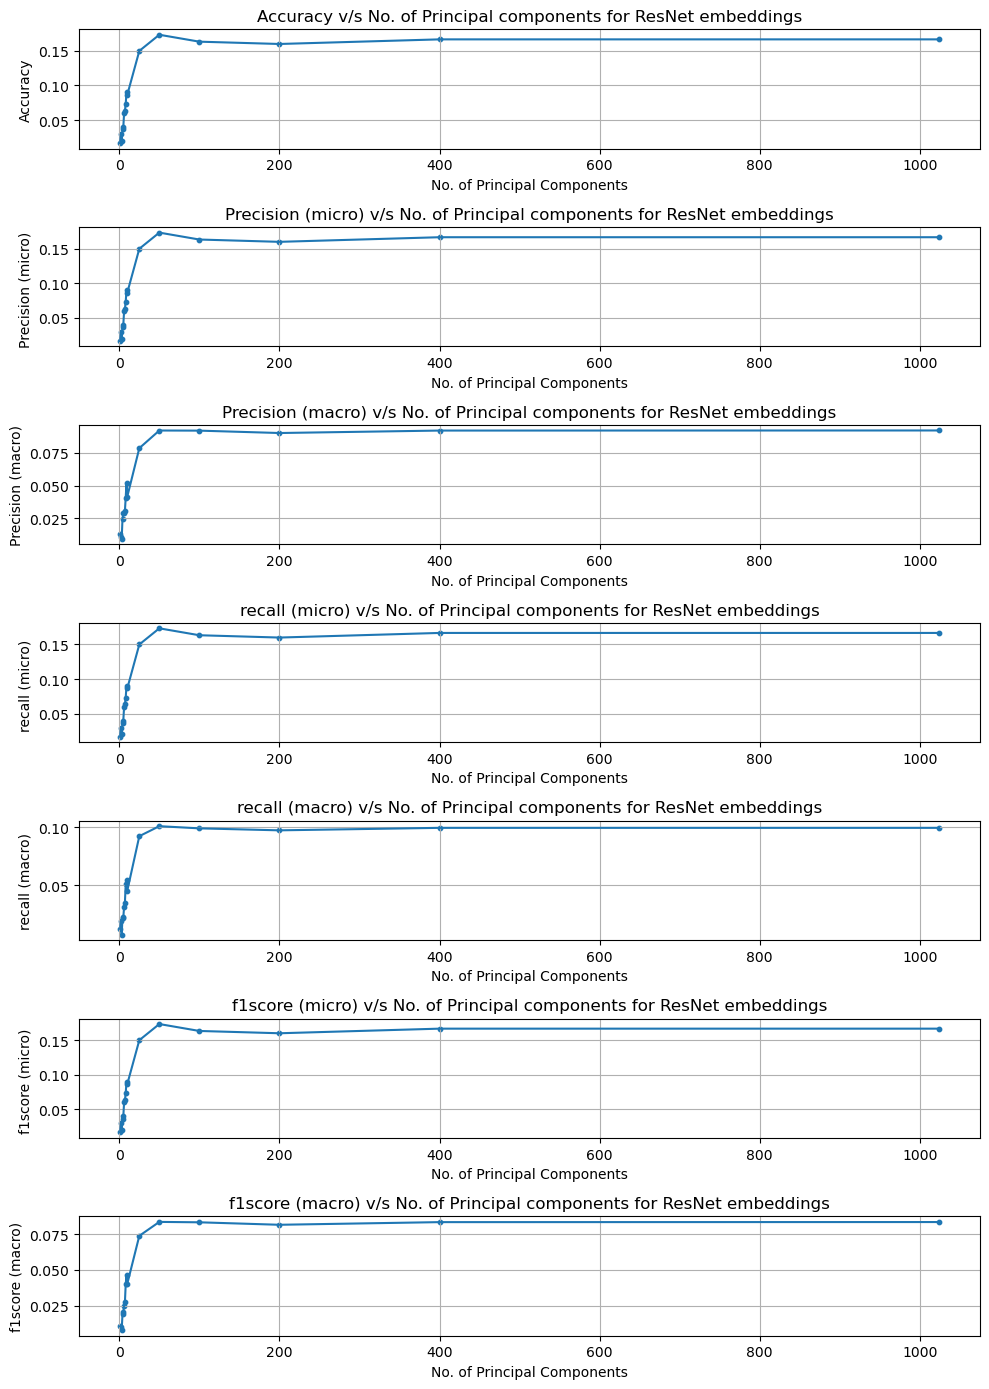

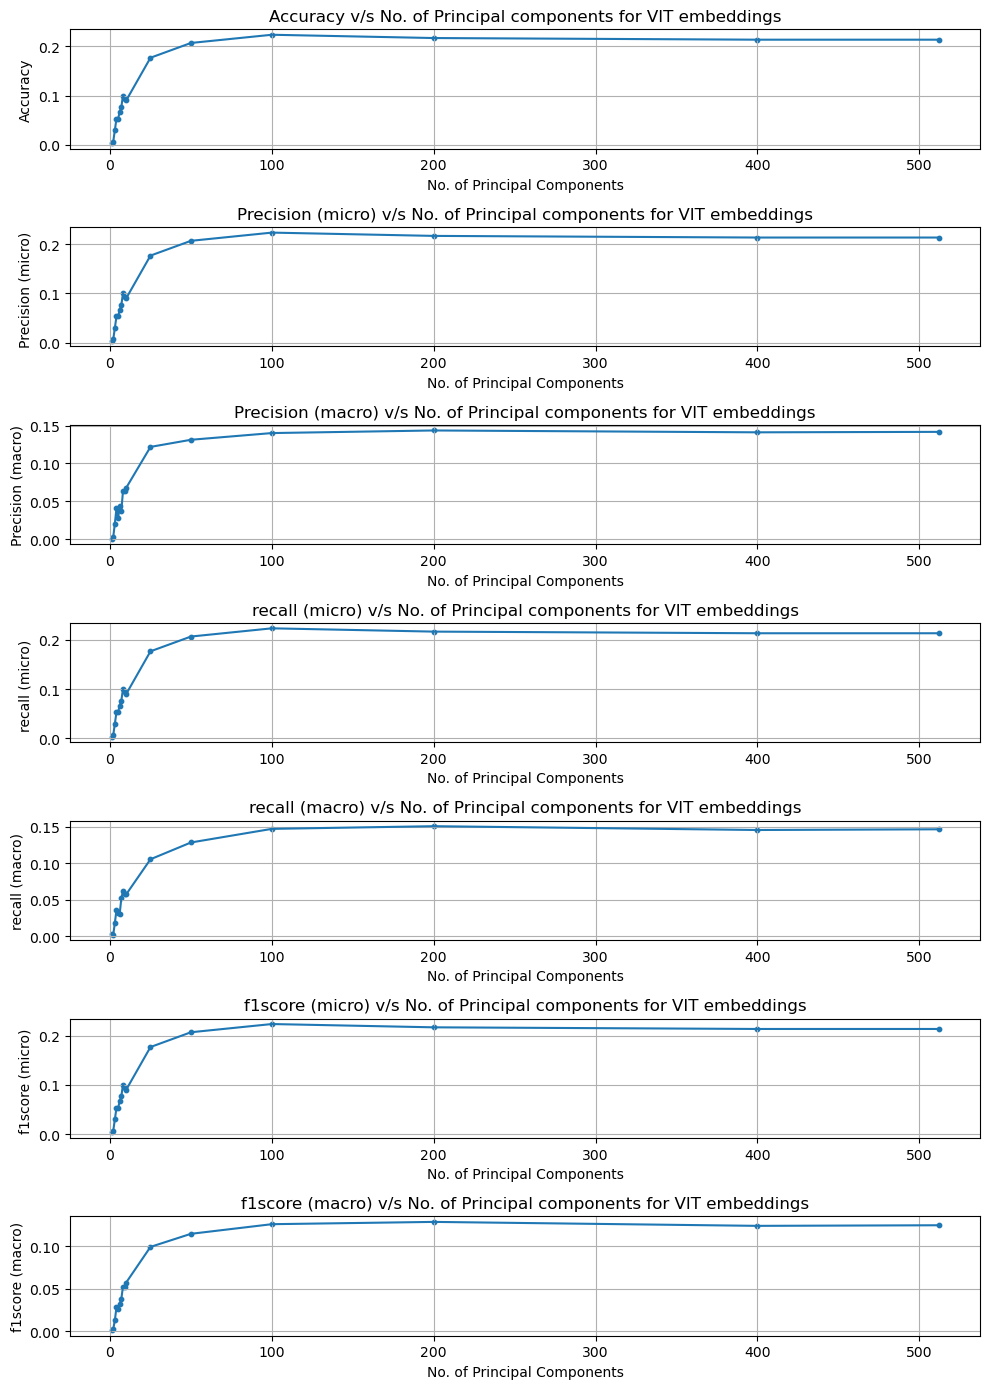

In [14]:
import warnings
warnings.filterwarnings('ignore')

evaluationPlotter(resnetEmbeddings,eVectorsResnet,yPictionary,"ResNet")
evaluationPlotter(vitEmbeddings,eVectorsVit,yPictionary,"VIT")

#### Observations
Initial Increase in Accuracy: You may notice that as you increase the number of principal components from a very low value, the accuracy of your model improves significantly. This initial increase indicates that the most important information is captured by the first few principal components.

Plateau Effect: After the initial increase, you might see that the accuracy improvement starts to level off or plateau. This suggests that adding more principal components doesn't provide significant additional information or discriminative power to the model.

Optimal Number of PCs: There may be a point on the plot where accuracy is maximized. This point represents the optimal number of principal components for your dataset and problem. Beyond this point, adding more PCs may lead to overfitting or computational overhead without improving accuracy.

#### Comparing accuracy with and without PCA

In [15]:
# Evalutating the model with PCA's
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def evaluationPlotter2(X,eigenVectors,y,embeddingType):
    k = 5
    accList = []
    nPCAcomponents = np.arange(1,len(eigenVectors),12)

    for PC in nPCAcomponents:
        xResnet = np.matmul(X,eigenVectors[0:PC].T)
        X_train, X_test, y_train, y_test = train_test_split(xResnet, y, test_size=0.2, random_state=42)

        model0 = KNeighborsClassifier(k)
        model0.fit(X_train,y_train)
        y_preds = model0.predict(X_test)
        
        accList.append(accuracy_score(y_test,y_preds))

    ####################
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model1 = KNeighborsClassifier(k)
    model1.fit(X_train,y_train)
    y_preds = model1.predict(X_test)
    acc = accuracy_score(y_test,y_preds)

    plt.figure(figsize=(10,3))
    plt.scatter(nPCAcomponents,acc*np.ones_like(accList),label="Without PCA",c='red',s=10)
    plt.plot(nPCAcomponents,acc*np.ones_like(accList),c='red')
    plt.scatter(nPCAcomponents,accList,label="With PCA",s=10)
    plt.plot(nPCAcomponents,accList)
    plt.xlabel("No. of Principal Components")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy v/s No. of Principal components for {embeddingType} embeddings")
    plt.grid()

    plt.legend()
    plt.tight_layout()
    plt.show()

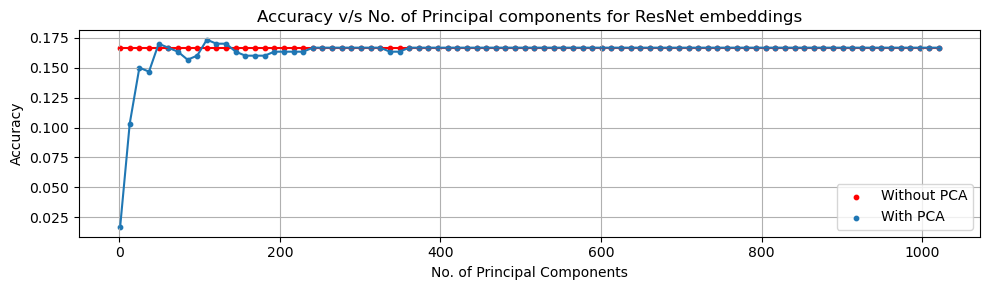

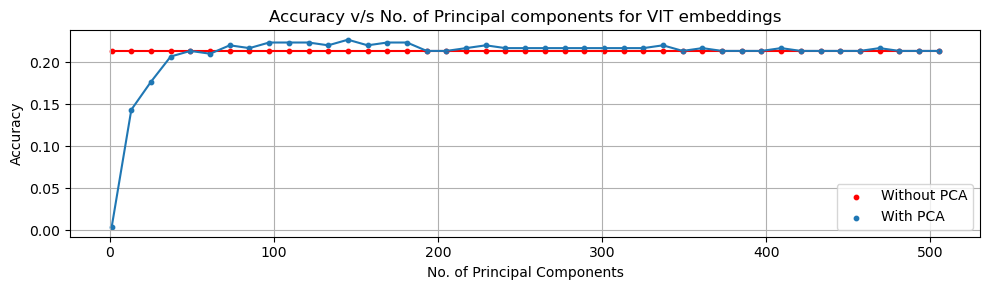

In [16]:
import warnings
warnings.filterwarnings('ignore')

evaluationPlotter2(resnetEmbeddings,eVectorsResnet,yPictionary,"ResNet")
evaluationPlotter2(vitEmbeddings,eVectorsVit,yPictionary,"VIT")

### 1.2 : Pictionary Dataset

In [17]:
import pandas as pd
import numpy as np
# PCA
drawerData = pd.read_csv("./bin/q1/drawer_attributes.csv").to_numpy()[:,1:]
guesserData = pd.read_csv("./bin/q1/guesser_attributes.csv").to_numpy()[:,1:]

eigenVectorsDrawer = PCAfunc(drawerData)[1]
eigenVectorsGuesser = PCAfunc(guesserData)[1]

drawerDataTransformed = np.matmul(drawerData,eigenVectorsDrawer)
guesserDataTransformed = np.matmul(guesserData,eigenVectorsGuesser)

In [18]:
# import matplotlib as plt

def threePCplot(newData,type):
    import plotly.graph_objects as go

    # Create a 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(x=newData[:,0], y=newData[:,1], z=newData[:,2], mode='markers')])
    fig.update_layout(
        scene=dict(
            xaxis_title='PC 1',
            yaxis_title='PC 2',
            zaxis_title='PC 3'
        ),
        title=f"Distribution of data along 3 PC ({type})"
    )

    fig.show()

threePCplot(drawerDataTransformed,"drawer data")
threePCplot(guesserDataTransformed,"guesser data")

In Principal Component Analysis (PCA), the new axes or principal components represent linear combinations of the original features in your dataset. Each principal component is a weighted sum of the original features, and they are orthogonal to each other, meaning they are uncorrelated.


First Principal Component (PC1):

Represents the direction in the data space along which the data varies the most.
It captures the most significant patterns, structures, or trends present in the data.
Often corresponds to the dominant mode of variation in the data.


Second Principal Component (PC2):

Represents the second most significant direction of variation orthogonal to PC1.
Captures patterns or structures that are uncorrelated with those in PC1.
It adds complementary information to PC1.


Third Principal Component (PC3) and Beyond:

Each subsequent principal component captures progressively less variance.
Represents directions of variation that are orthogonal to the previous components.
Each component provides unique, uncorrelated information about the data.